## Grouping by season in order to plot along elevation.

In [2]:
import s3fs
import xarray as xr
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

In [3]:
varl = ['N100','N200','N50', 'BC_AI'] 

In [4]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_full/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc'

In [5]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [6]:
filelist = [make_file_path_for_var(v) for v in varl]

In [7]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

In [8]:
sulphate_varl = ['SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC','SO4_PR'] 

In [9]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [10]:
filelist = [make_file_path_for_var(v) for v in sulphate_varl]

In [11]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

In [12]:
ds['SO4_tot'] = 0
for var in sulphate_varl:
    ds['SO4_tot'] = ds['SO4_tot'] + ds[var]

ds['SO4_tot'].attrs['units'] = ds[var].attrs['units']

In [13]:
T_standard =  273.15 #K
p_standard = 1e5 #Pa
R = 287.058

rho = p_standard/(R*T_standard)
rho

1.2753492774515685

In [14]:
var = 'SO4_tot'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'
                

In [15]:
filelist = [make_file_path_for_var(v) for v in varl]

In [16]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds_aero = xr.open_mfdataset(list_of_s3_obj)

In [17]:
import matplotlib.pyplot as plt

In [18]:
ds =xr.merge([ds,ds_aero])

In [19]:
ds_season = ds.groupby('time.season').mean()
ds_season['SO4_tot'].attrs['units'] = 'ug/m3'
ds_season['SO4_tot'].attrs['long_name'] = 'Total Sulphate Concentration'
ds_season['N100'].attrs['units'] = 'm$^-3$'
ds_season['N100'].attrs['long_name'] = 'N$_100$'
ds_season

<xarray.Dataset>
Dimensions:   (location: 5, season: 4, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    SO4_A1    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_A2    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_AC    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_NA    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_PR    (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    SO4_tot   (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    BC_AI     (location, season, lev) float32 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N100      (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N200      (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>
    N50       (location, season, lev) float64 dask.array<chunksize=(5, 1, 32), meta=np.ndarray>

In [20]:
ds_season = ds_season.load()

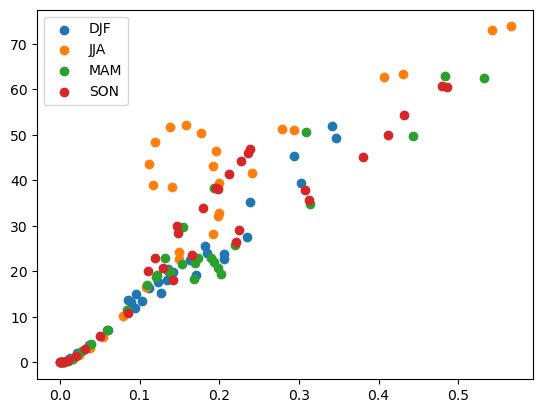

In [21]:
for seas in ds_season.season:
    plt.scatter(x = ds_season['SO4_tot'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['N100'].sel(season=seas,location = 'Zeppelin'),
                label=seas.values)
                
plt.legend()

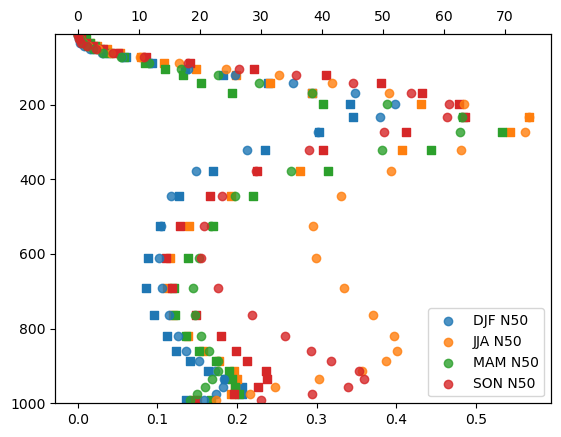

In [22]:
ig, ax1 = plt.subplots()

for seas in ds_season.season:
    ax1.scatter(x = ds_season['SO4_tot'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['lev'],
                marker = 's',
                label=f'{seas.values} SO4')
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2 = ax1.twiny() 
for seas in ds_season.season:
    ax2.scatter(x = ds_season['N100'].sel(season=seas,location = 'Zeppelin'), 
                y = ds_season['lev'],
                label=f'{seas.values} N50', alpha = 0.8)

ax1.set_ylim([1000,10])
plt.legend()

In [23]:
percentage_SO4 = (ds_season['SO4_tot']/(ds_season['SO4_tot'].max()))
percentage_N100 = (ds_season['N100']/(ds_season['N100'].max()))
percentage_SO4 = percentage_SO4.load()
percentage_N100 = percentage_N100.load()

In [24]:
factor = percentage_SO4 / percentage_N100
N100_div_SO4 = percentage_N100/percentage_SO4

(1042.0017265947536, -45.80216577742249)

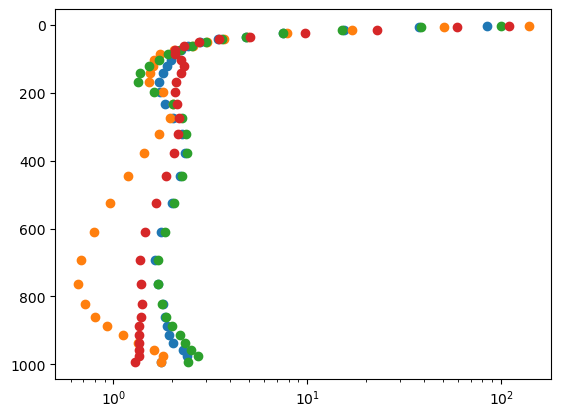

In [25]:
fig, ax = plt.subplots()
for seas in factor.season:
    ax.scatter(x= factor.sel(season=seas,location = 'Zeppelin'),
               y= factor['lev'],
              label=seas.values)
ax.set_xscale('log')
ax.set_ylim(ax.get_ylim()[::-1])

(1042.0017265947536, -45.80216577742249)

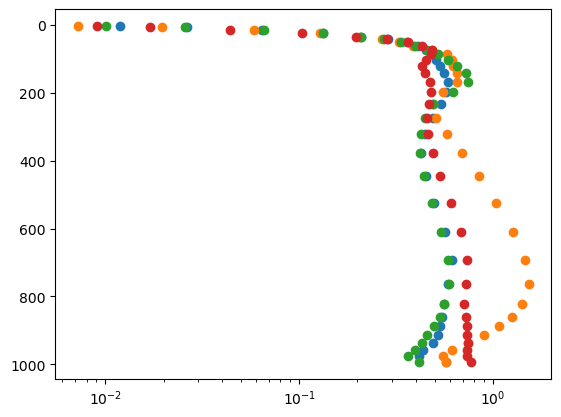

In [26]:
fig, ax = plt.subplots()
for seas in N100_div_SO4.season:
    ax.scatter(x= N100_div_SO4.sel(season=seas,location = 'Zeppelin'),
               y= N100_div_SO4['lev'],
              label=seas.values)
ax.set_xscale('log')
ax.set_ylim(ax.get_ylim()[::-1])

## Daily resample and the N50 and N100 ploted against SO4 total

In [27]:
ds_daily = ds.resample(time='d').mean('time')
ds_daily['season']= ds_daily['time.season']

ds_daily

<xarray.Dataset>
Dimensions:   (location: 5, time: 1098, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_A2    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_AC    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_NA    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_PR    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_tot   (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    BC_AI     (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    season    (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

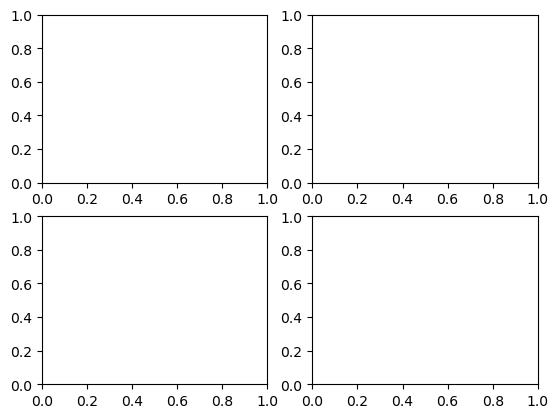

In [28]:
fig, axs = plt.subplots(2,2)



In [29]:
ds_daily

<xarray.Dataset>
Dimensions:   (location: 5, time: 1098, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_A2    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_AC    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_NA    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_PR    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_tot   (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    BC_AI     (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    season    (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

In [30]:
_ds = ds_daily.sel(location='Zeppelin').isel(lev=-1)


_ds =_ds.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [31]:
_ds['season'] = _ds['time.season']

In [32]:
import numpy as np

DJF
 
234.5 x + 16.4
MAM
 
344.3 x + 25.05
JJA
 
325.9 x + 31.91
SON
 
450.5 x + 1.657


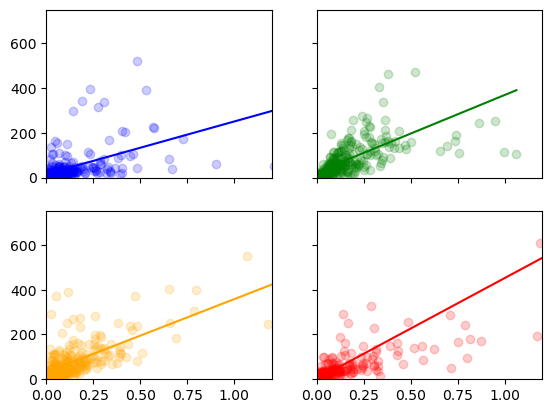

In [33]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.linspace(_dss['SO4_tot'].min(), _dss['SO4_tot'].max())
    ax.plot( x, p(x), c = col, )
    print(p)
    ax.set_ylim ([0,750])
    ax.set_xlim ([0,1.2])
    #ax.set_yscale ('log')
    #ax.set_xscale ('log')

DJF
 
234.5 x + 16.4
MAM
 
344.3 x + 25.05
JJA
 
325.9 x + 31.91
SON
 
450.5 x + 1.657


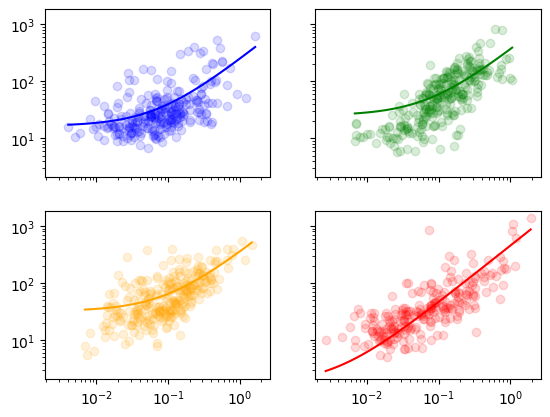

In [34]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'],c= col, alpha = 0.15)
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = col, )
    print(p)
    #ax.set_ylim ([0,750])
    #ax.set_xlim ([0,1.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
MAM
JJA
SON


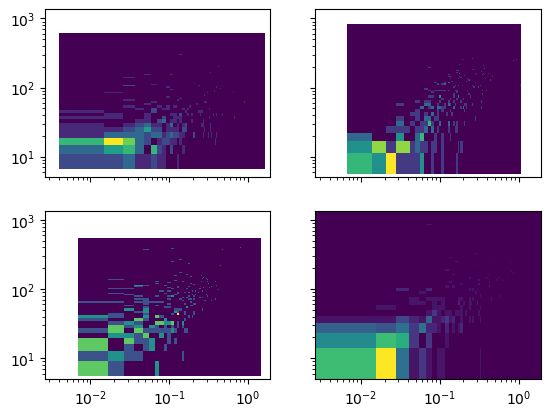

In [35]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.hist2d(x=_dss['SO4_tot'], y=_dss['N50'],bins = 150)
    #z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    #p = np.poly1d(z)
    #ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
 
124.6 x + 3.773
MAM
 
82.24 x + 4.635
JJA
 
113.6 x + 5.653
SON
 
173.3 x + 2.375


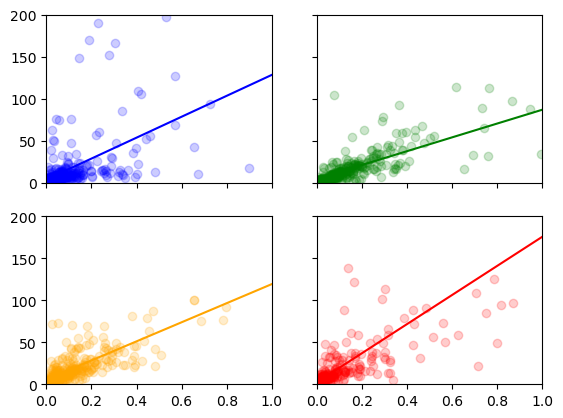

In [36]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.linspace(_dss['SO4_tot'].min(), _dss['SO4_tot'].max())
    ax.plot( x, p(x), c = col, )
    print(p)
    ax.set_ylim ([0,200])
    ax.set_xlim ([0,1])
    #ax.set_yscale ('log')
    #ax.set_xscale ('log')

DJF
 
124.6 x + 3.773
MAM
 
82.24 x + 4.635
JJA
 
113.6 x + 5.653
SON
 
173.3 x + 2.375


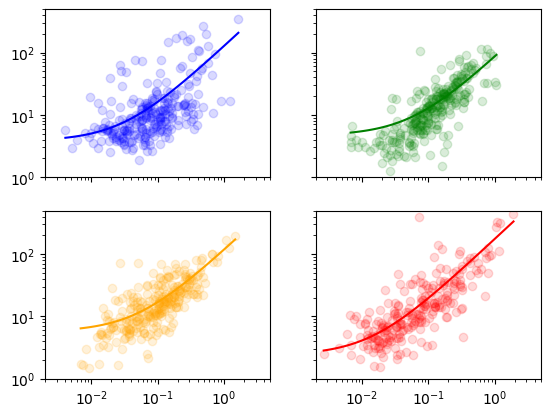

In [37]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'],c= col, alpha = 0.15)
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = col, )
    print(p)
    ax.set_ylim ([1,500])
    ax.set_xlim ([0.002,5])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
MAM
JJA
SON


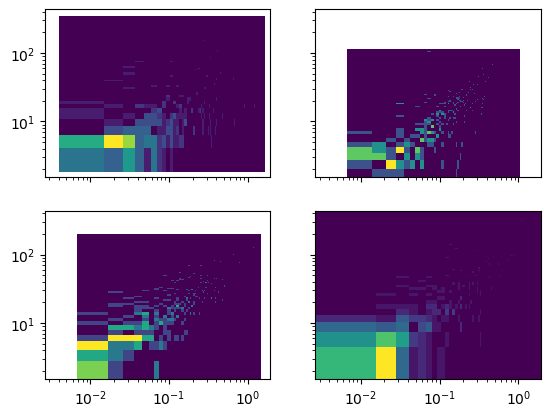

In [38]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.hist2d(x=_dss['SO4_tot'], y=_dss['N100'],bins = 150, )
    #z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    #p = np.poly1d(z)
    #ax.plot( _dss['SO4_tot'], p( _dss['SO4_tot']), c = col, )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

DJF
MAM
JJA
SON


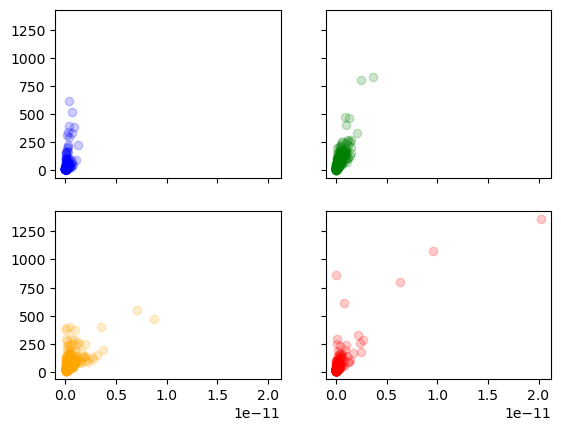

In [39]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    print(seas)
    _dss = _ds.where(_ds['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['BC_AI'], y=_dss['N50'],c= col, alpha = 0.2)
    #z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    #p = np.poly1d(z)
    #x= np.linspace(_dss['SO4_tot'].min(), _dss['SO4_tot'].max())
    #ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,750])
    #ax.set_xlim ([0,1.2])
    #ax.set_yscale ('log')
    #ax.set_xscale ('log')

## R-squared values for the sason and measurement level.

In [40]:
ds_daily

<xarray.Dataset>
Dimensions:   (location: 5, time: 1098, lev: 32)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_A2    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_AC    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_NA    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_PR    (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    SO4_tot   (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    BC_AI     (location, time, lev) float32 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 1098, 32), meta=np.ndarray>
    season    (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

In [41]:
winter_daily = ds_daily.sel(location='Zeppelin').where(ds_daily['season']== 'DJF')
winter_daily = winter_daily.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [42]:
winter_daily['lev']

<xarray.DataArray 'lev' (lev: 32)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  35.92325 ,  43.19375 ,
        51.677499,  61.520498,  73.750958,  87.82123 , 103.317127, 121.547241,
       142.994039, 168.22508 , 197.908087, 232.828619, 273.910817, 322.241902,
       379.100904, 445.992574, 524.687175, 609.778695, 691.38943 , 763.404481,
       820.858369, 859.534767, 887.020249, 912.644547, 936.198398, 957.48548 ,
       976.325407, 992.556095])
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    location  <U8 'Zeppelin'

In [43]:
spring_daily = ds_daily.sel(location='Zeppelin').where(ds_daily['season']== 'MAM')
spring_daily = spring_daily.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [44]:
summer_daily = ds_daily.sel(location='Zeppelin').where(ds_daily['season']== 'JJA')
summer_daily = summer_daily.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [45]:
fall_daily = ds_daily.sel(location='Zeppelin').where(ds_daily['season']== 'SON')
fall_daily = fall_daily.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [46]:
import seaborn as sns

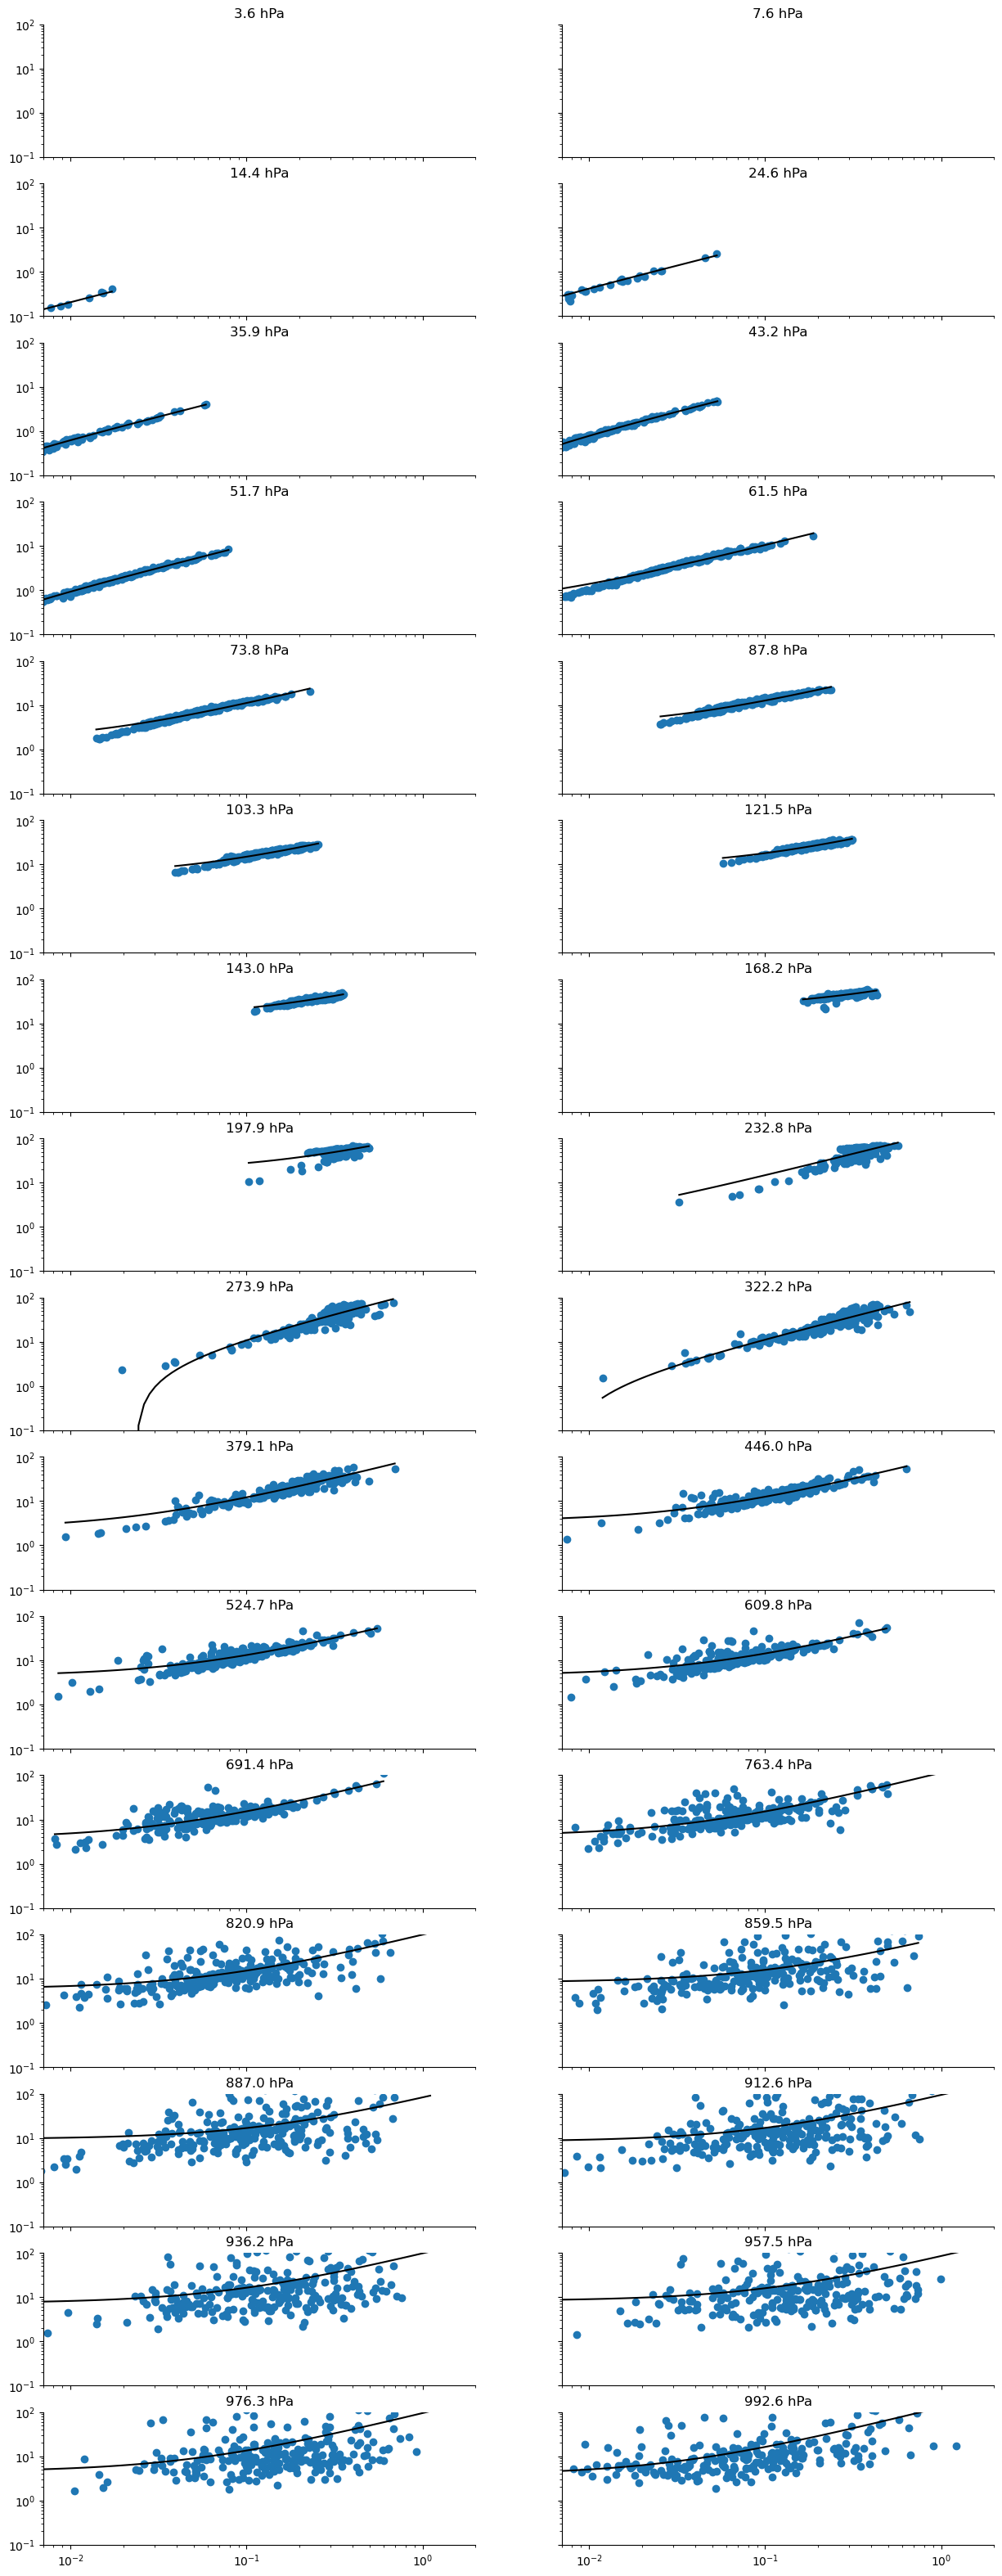

In [47]:
fig, axs = plt.subplots(16,2, sharex=True, sharey=True, figsize = [15,40])

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(winter_daily['lev'], axs.flatten()):
    #print(lev)
    _dss = winter_daily.where(winter_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    #dpi = 100
    #print(p)
    ax.set_ylim ([0.1,100])
    ax.set_xlim ([0.007,2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(f'{lev.values:.1f} hPa')
sns.despine(fig)

<xarray.DataArray 'lev' ()>
array(3.64346569)
Coordinates:
    lev       float64 3.643
    location  <U8 'Zeppelin'
 
2.968 x - 0.0004091
<xarray.DataArray 'lev' ()>
array(7.59481965)
Coordinates:
    lev       float64 7.595
    location  <U8 'Zeppelin'
 
10.57 x - 0.009689
<xarray.DataArray 'lev' ()>
array(14.35663225)
Coordinates:
    lev       float64 14.36
    location  <U8 'Zeppelin'
 
26.03 x - 0.04482
<xarray.DataArray 'lev' ()>
array(24.61222)
Coordinates:
    lev       float64 24.61
    location  <U8 'Zeppelin'
 
46.16 x - 0.1083
<xarray.DataArray 'lev' ()>
array(35.92325002)
Coordinates:
    lev       float64 35.92
    location  <U8 'Zeppelin'
 
66.31 x - 0.1714
<xarray.DataArray 'lev' ()>
array(43.19375008)
Coordinates:
    lev       float64 43.19
    location  <U8 'Zeppelin'
 
82.06 x - 0.1958
<xarray.DataArray 'lev' ()>
array(51.67749897)
Coordinates:
    lev       float64 51.68
    location  <U8 'Zeppelin'
 
93.61 x - 0.1369
<xarray.DataArray 'lev' ()>
array(61.52049825)


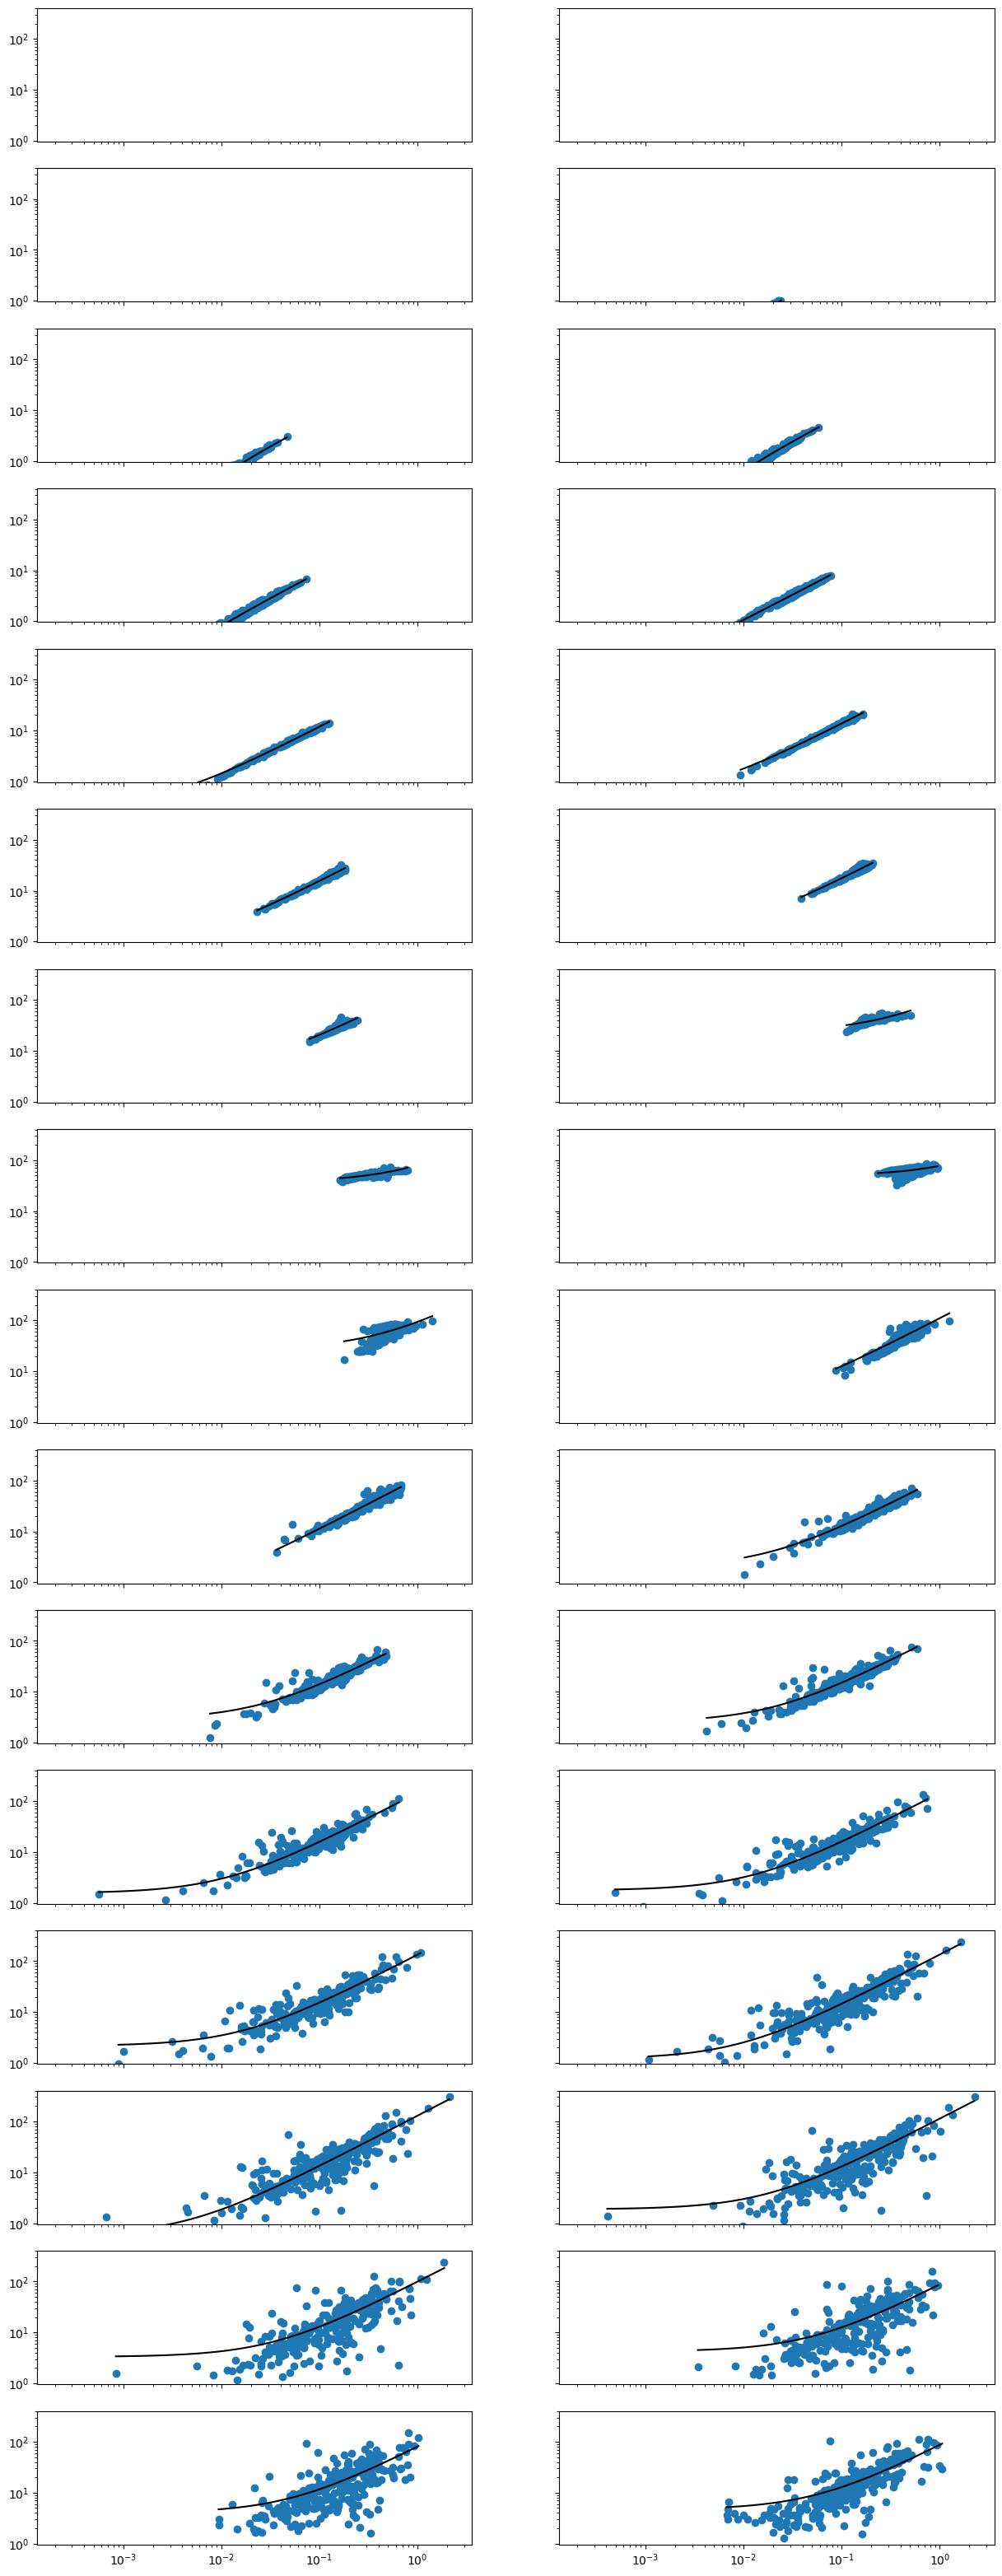

In [48]:
fig, axs = plt.subplots(16,2, figsize = [15,40], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(spring_daily['lev'], axs.flatten()):
    print(lev)
    _dss = spring_daily.where(spring_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')



<xarray.DataArray 'lev' ()>
array(3.64346569)
Coordinates:
    lev       float64 3.643
    location  <U8 'Zeppelin'
 
2.201 x - 4.289e-05
<xarray.DataArray 'lev' ()>
array(7.59481965)
Coordinates:
    lev       float64 7.595
    location  <U8 'Zeppelin'
 
7.499 x - 0.002776
<xarray.DataArray 'lev' ()>
array(14.35663225)
Coordinates:
    lev       float64 14.36
    location  <U8 'Zeppelin'
 
24.42 x - 0.03838
<xarray.DataArray 'lev' ()>
array(24.61222)
Coordinates:
    lev       float64 24.61
    location  <U8 'Zeppelin'
 
49.32 x - 0.1495
<xarray.DataArray 'lev' ()>
array(35.92325002)
Coordinates:
    lev       float64 35.92
    location  <U8 'Zeppelin'
 
74.27 x - 0.3286
<xarray.DataArray 'lev' ()>
array(43.19375008)
Coordinates:
    lev       float64 43.19
    location  <U8 'Zeppelin'
 
95.84 x - 0.6039
<xarray.DataArray 'lev' ()>
array(51.67749897)
Coordinates:
    lev       float64 51.68
    location  <U8 'Zeppelin'
 
97.76 x - 0.392
<xarray.DataArray 'lev' ()>
array(61.52049825)
C

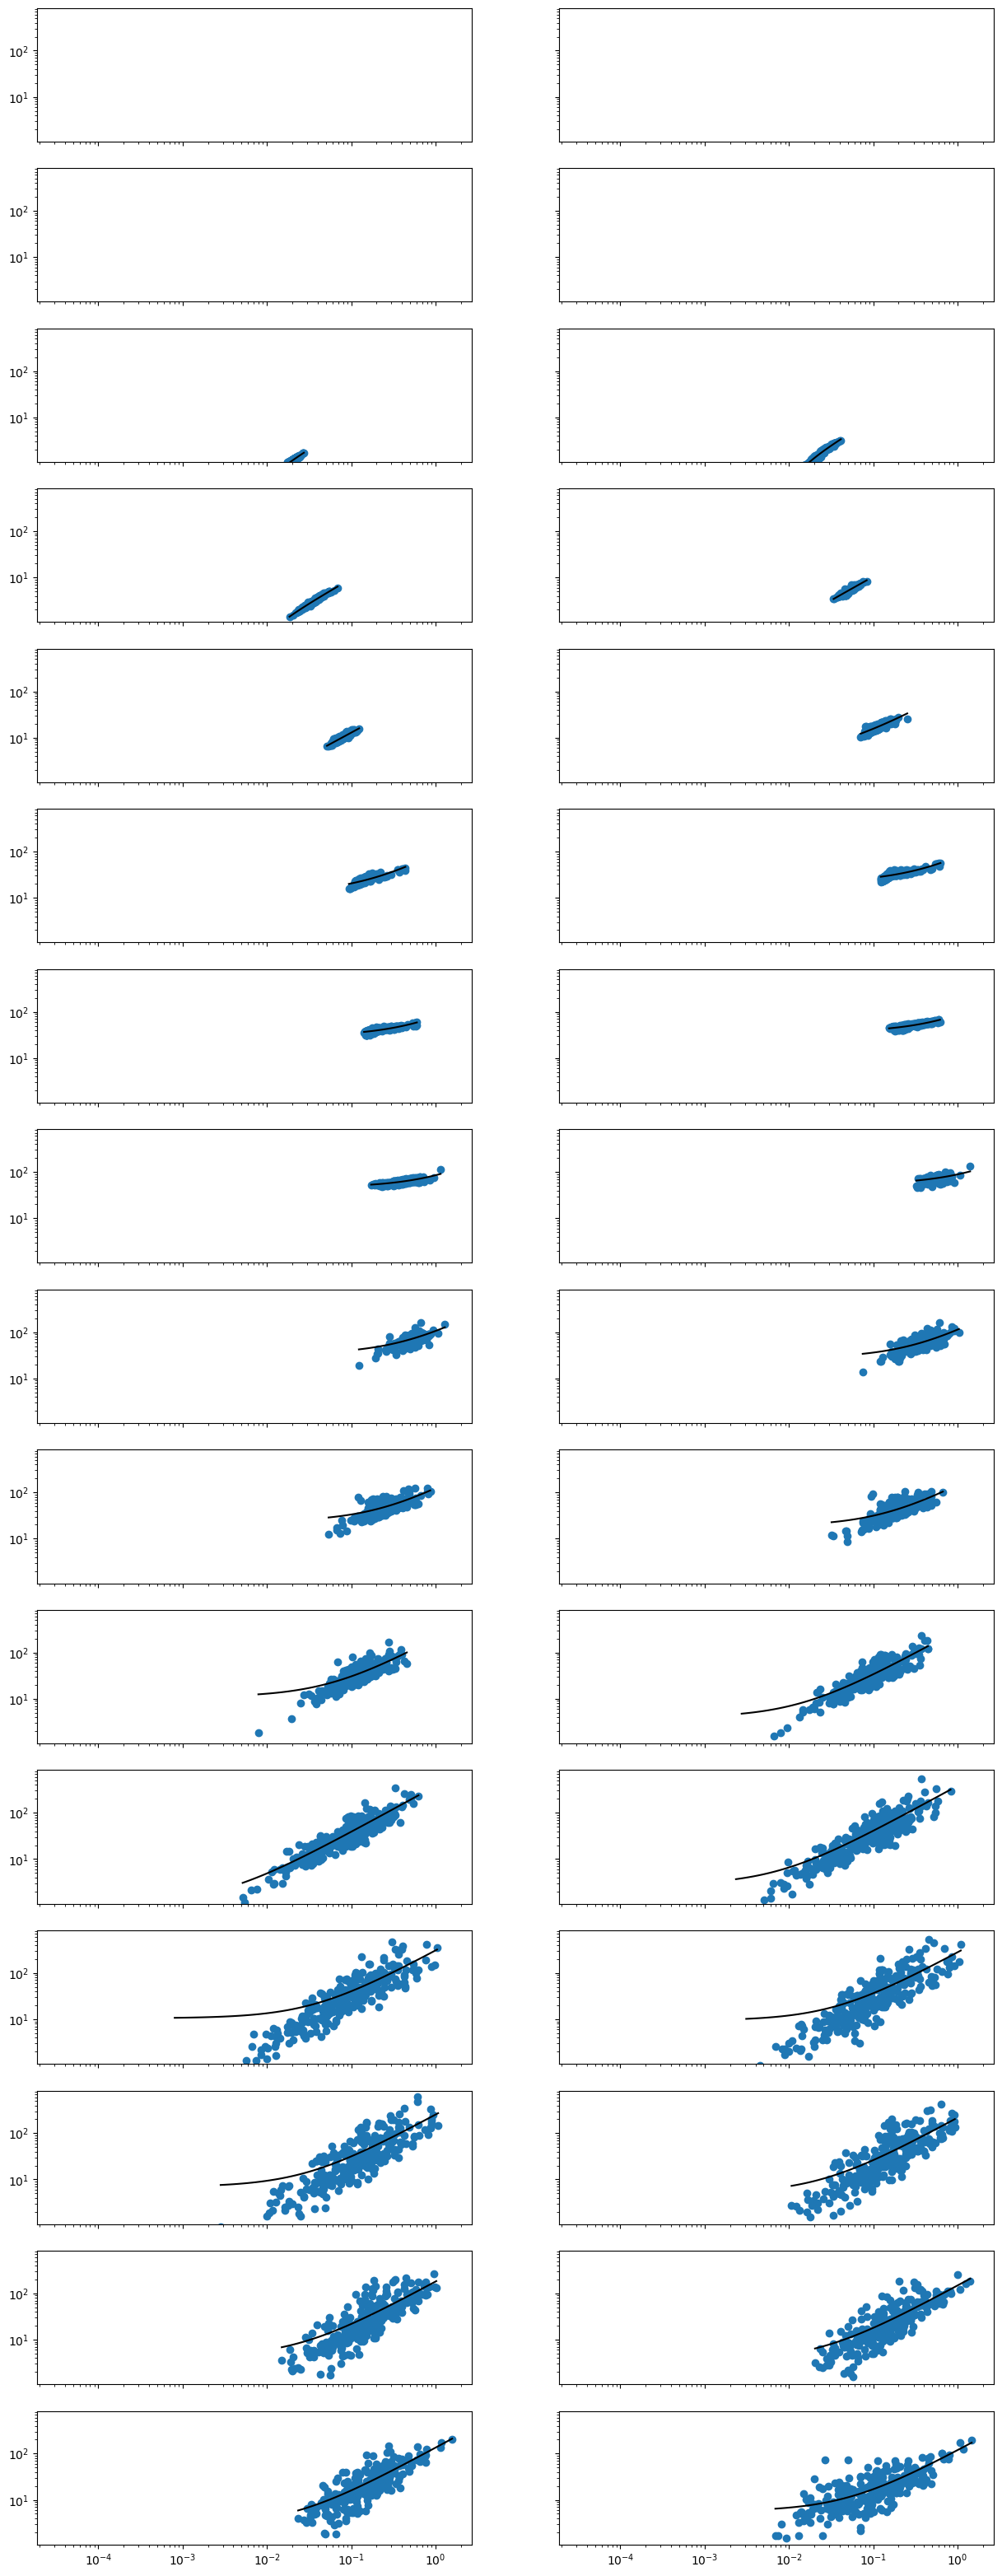

In [49]:
fig, axs = plt.subplots(16,2, figsize = [15,40], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(summer_daily['lev'], axs.flatten()):
    print(lev)
    _dss = summer_daily.where(summer_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

<xarray.DataArray 'lev' ()>
array(3.64346569)
Coordinates:
    lev       float64 3.643
    location  <U8 'Zeppelin'
 
3.062 x - 1.161e-05
<xarray.DataArray 'lev' ()>
array(7.59481965)
Coordinates:
    lev       float64 7.595
    location  <U8 'Zeppelin'
 
5.439 x - 9.051e-05
<xarray.DataArray 'lev' ()>
array(14.35663225)
Coordinates:
    lev       float64 14.36
    location  <U8 'Zeppelin'
 
13.48 x - 0.002061
<xarray.DataArray 'lev' ()>
array(24.61222)
Coordinates:
    lev       float64 24.61
    location  <U8 'Zeppelin'
 
36.66 x - 0.03981
<xarray.DataArray 'lev' ()>
array(35.92325002)
Coordinates:
    lev       float64 35.92
    location  <U8 'Zeppelin'
 
67.76 x - 0.1709
<xarray.DataArray 'lev' ()>
array(43.19375008)
Coordinates:
    lev       float64 43.19
    location  <U8 'Zeppelin'
 
89.3 x - 0.3125
<xarray.DataArray 'lev' ()>
array(51.67749897)
Coordinates:
    lev       float64 51.68
    location  <U8 'Zeppelin'
 
107.1 x - 0.438
<xarray.DataArray 'lev' ()>
array(61.52049825)

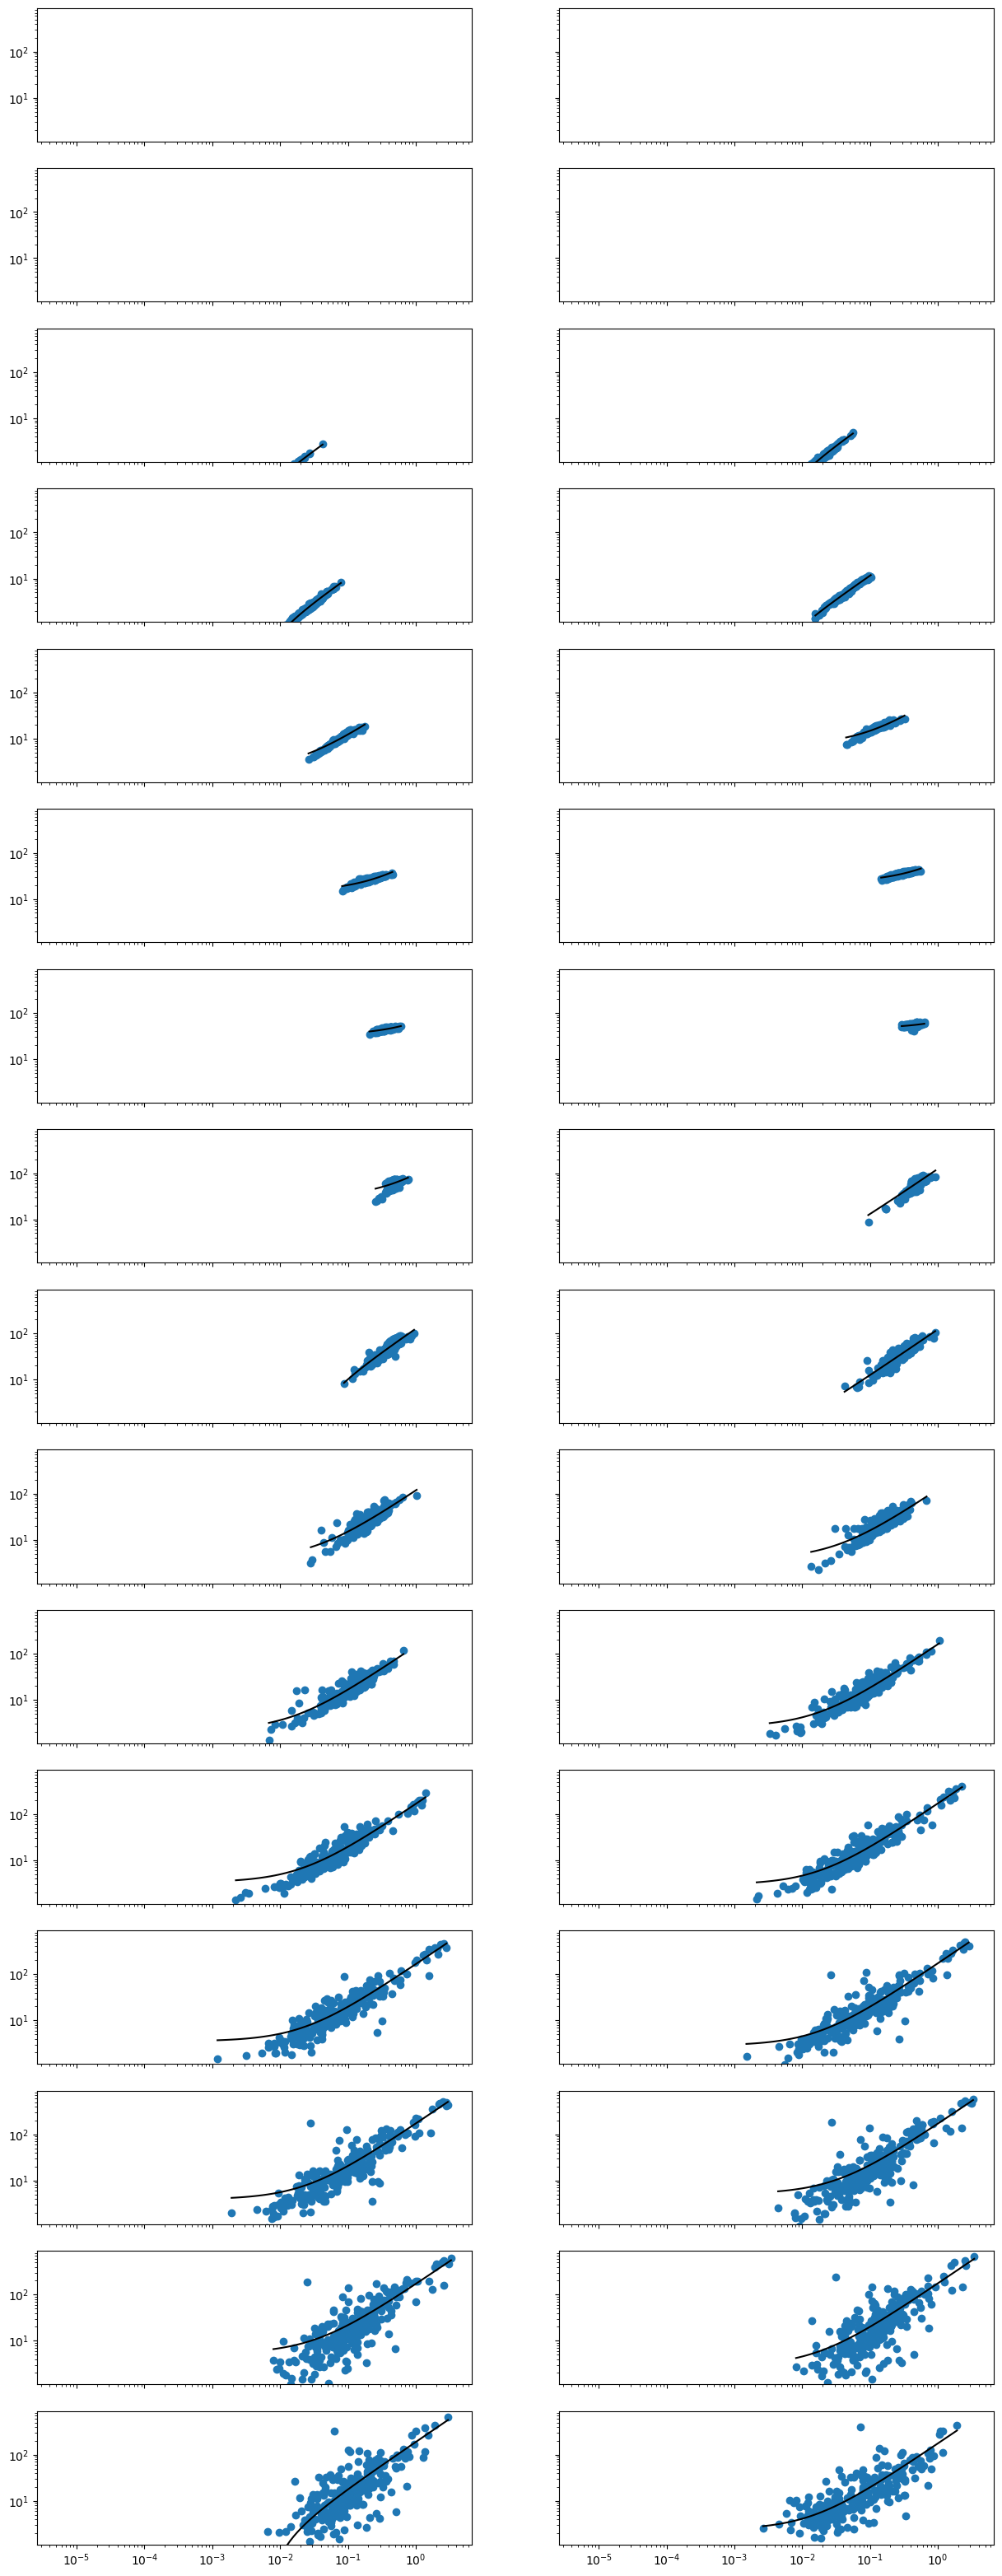

In [50]:
fig, axs = plt.subplots(16,2, figsize = [15,40], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(fall_daily['lev'], axs.flatten()):
    print(lev)
    _dss = fall_daily.where(fall_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N100'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')

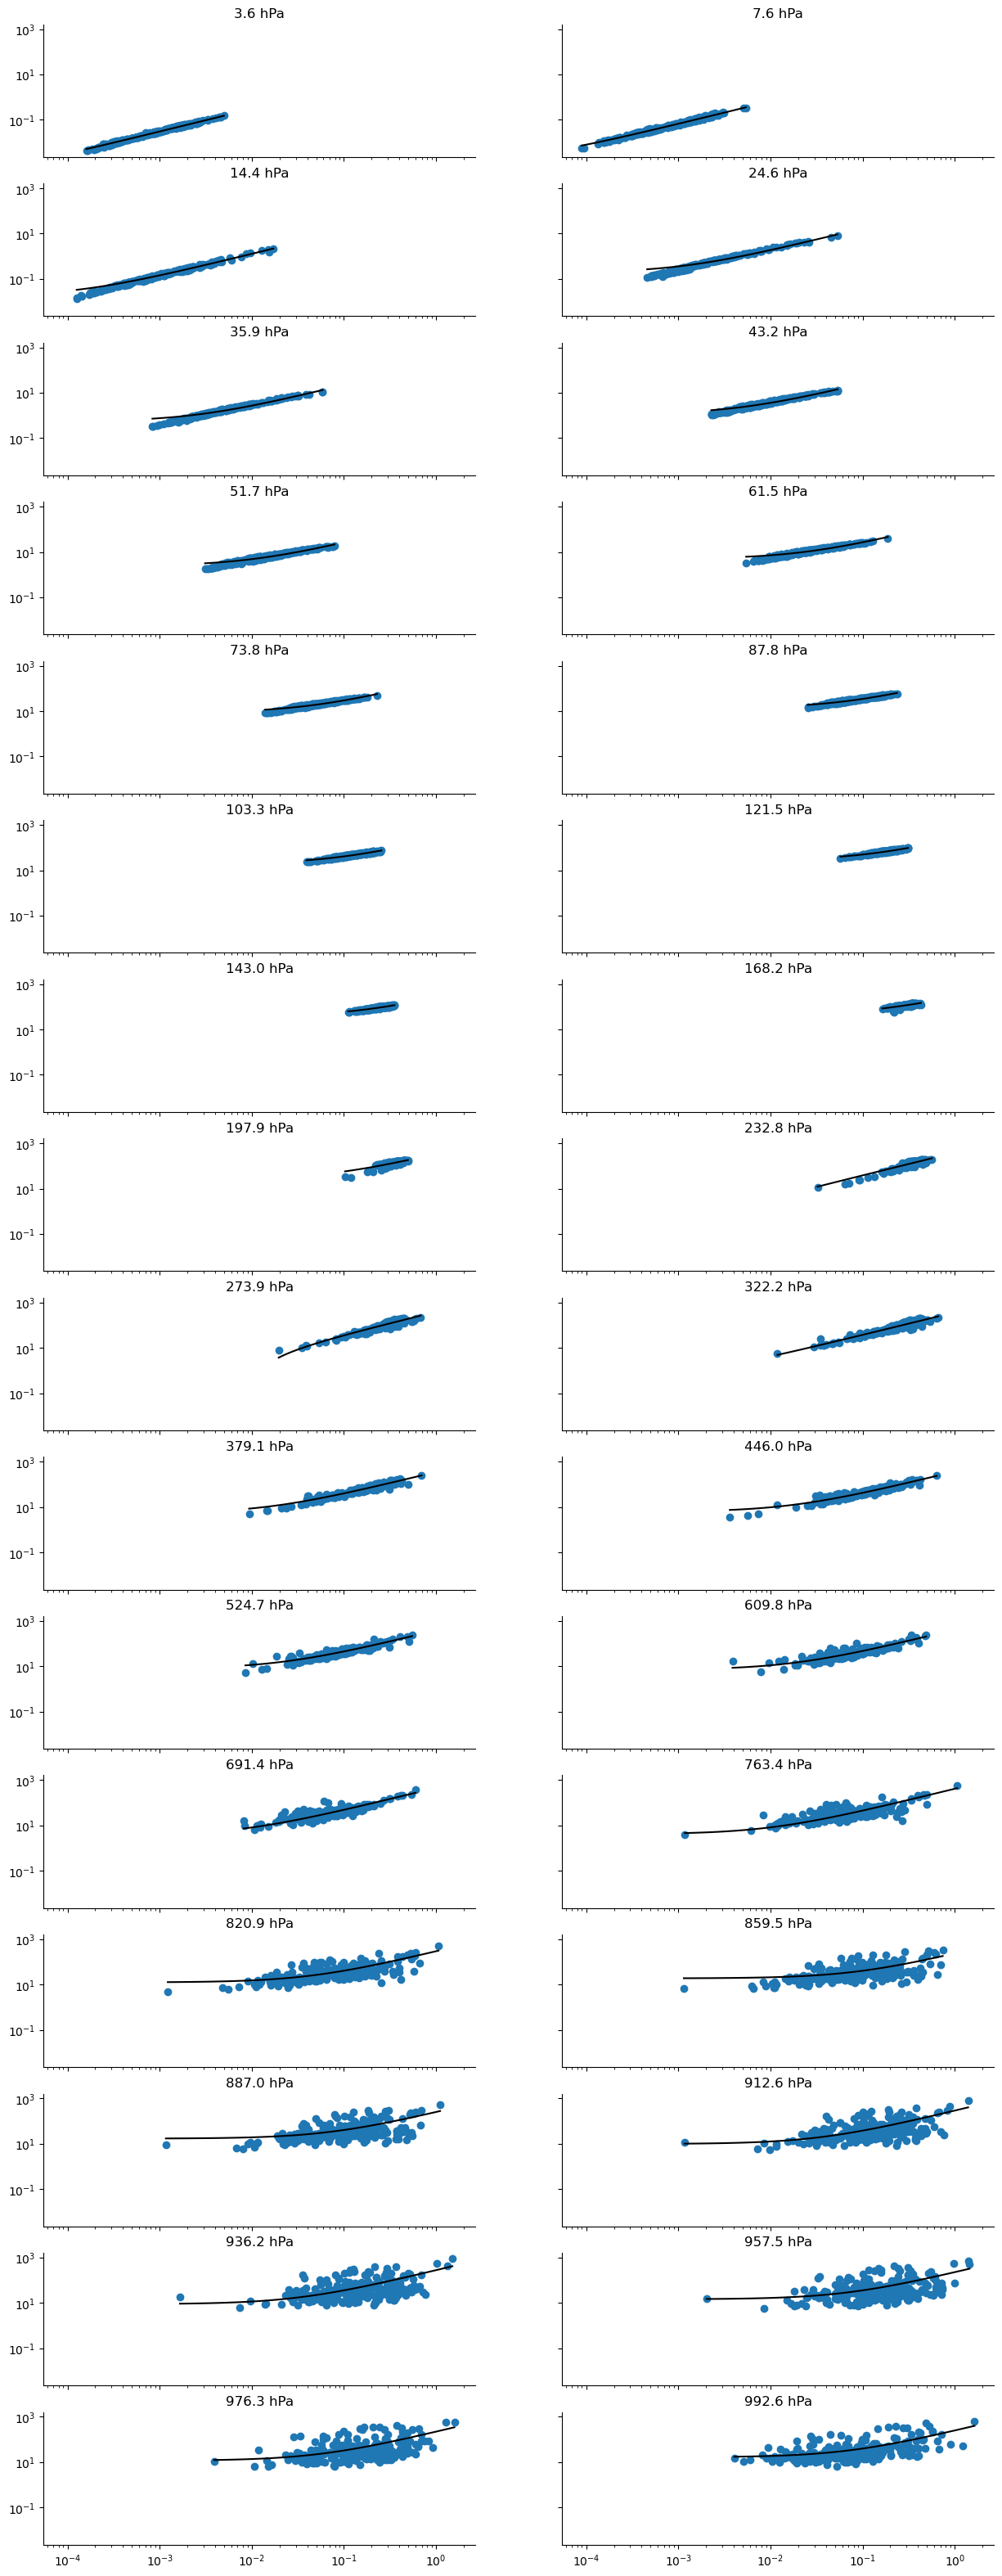

In [123]:
fig, axs = plt.subplots(16,2, figsize = [15,40], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(winter_daily['lev'], axs.flatten()):
    #print(lev)
    _dss = winter_daily.where(winter_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(f'{lev.values:.1f} hPa')
sns.despine(fig)

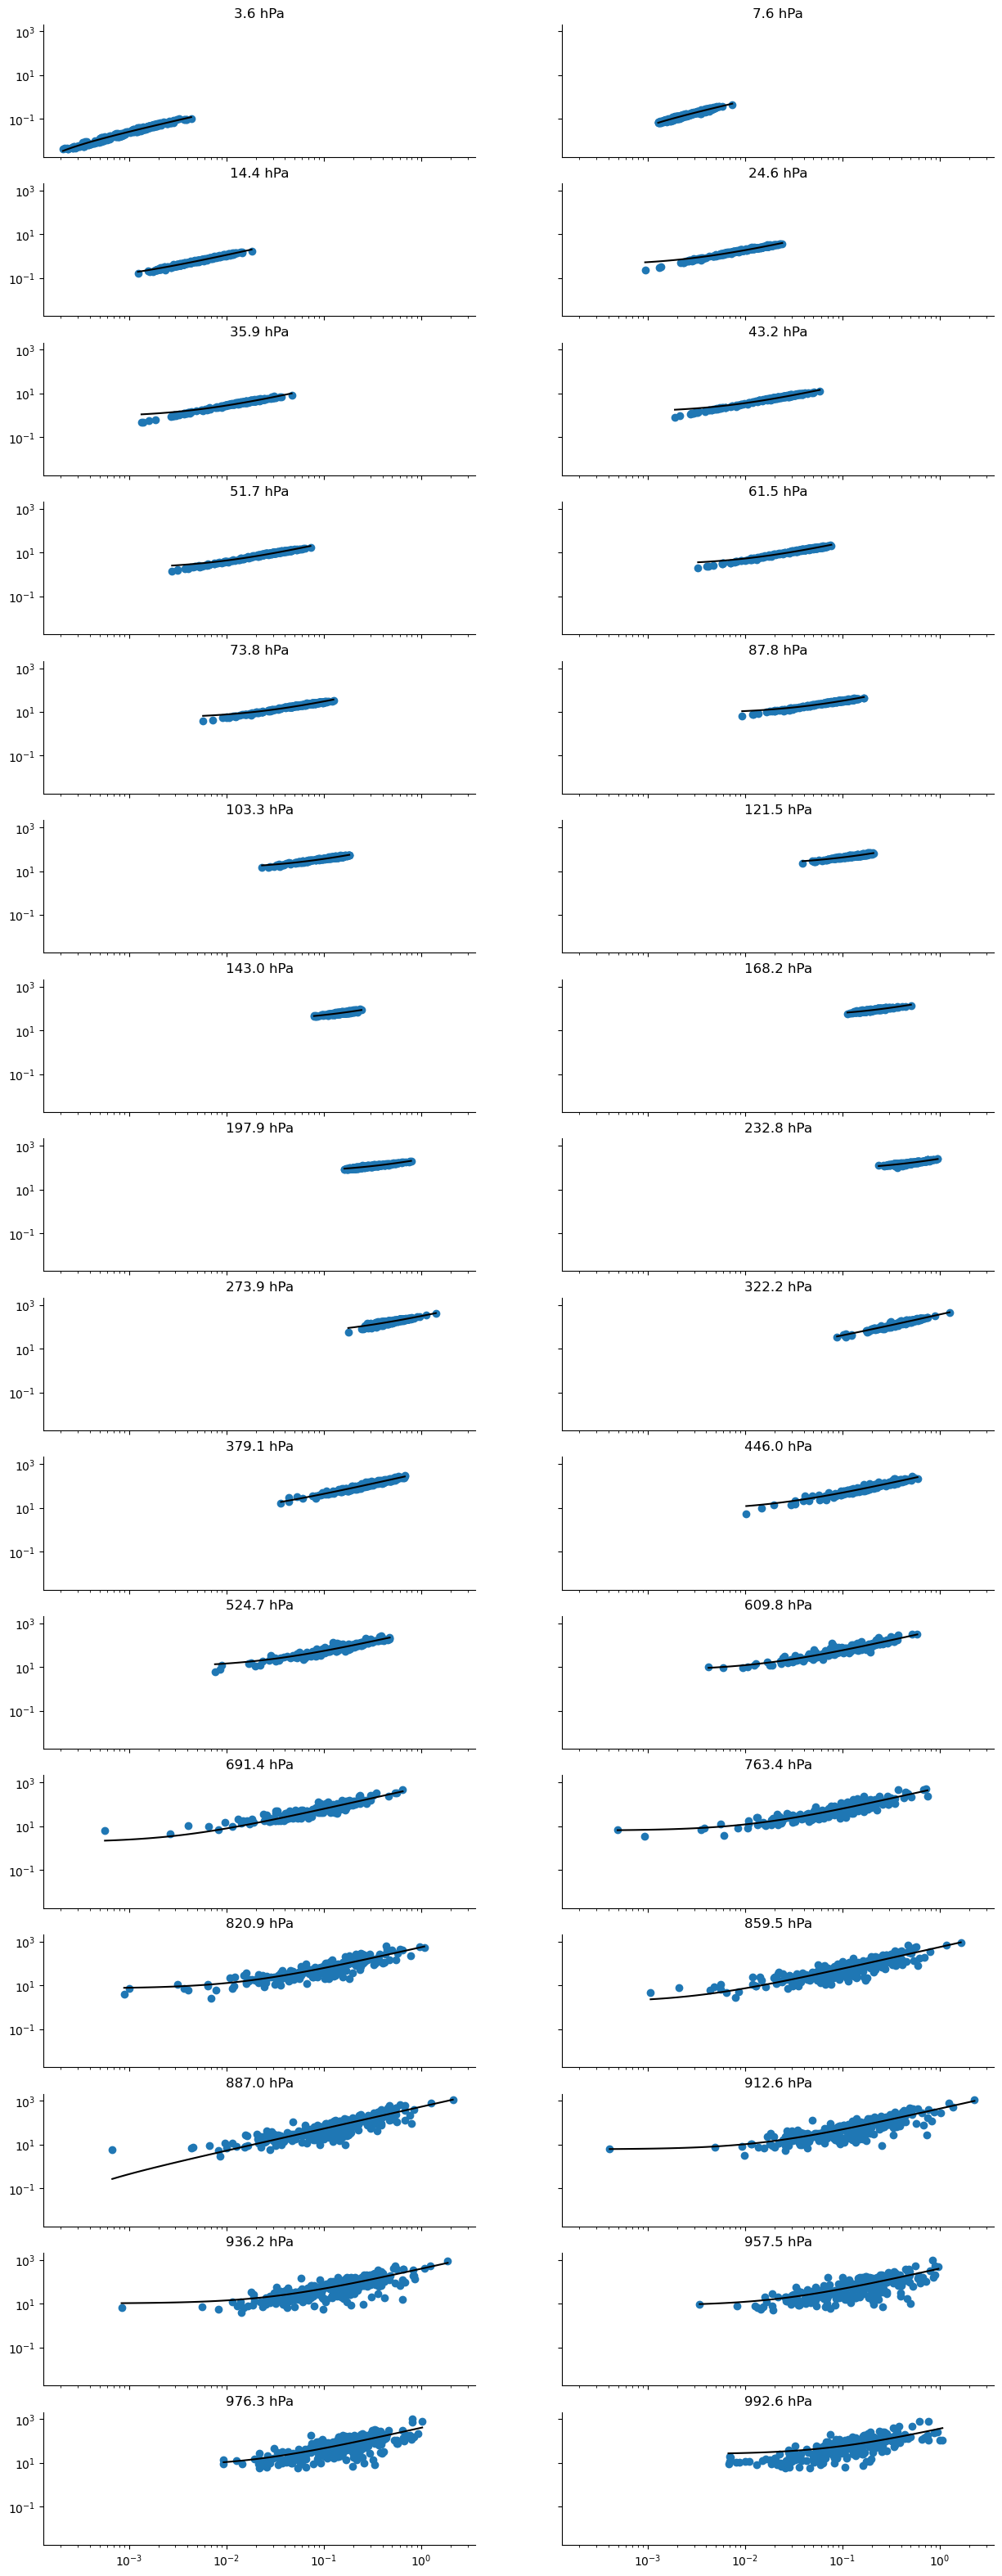

In [122]:
fig, axs = plt.subplots(16,2, figsize = [15,40], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(spring_daily['lev'], axs.flatten()):
    #print(lev)
    _dss = spring_daily.where(spring_daily['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_tot'], y=_dss['N50'] )
    z = np.polyfit(_dss['SO4_tot'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_tot'].min()), np.log10(_dss['SO4_tot'].max()))
    ax.plot( x, p(x), c = 'black', )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(f'{lev.values:.1f} hPa')
sns.despine(fig)

In [51]:
from sklearn.linear_model import LinearRegression
model = LinearRegression
X = winter_daily['N50']
y = winter_daily['SO4_tot']
model.fit(X , y)
r_squared = model.score(X,y)
print(r_squared)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
from sklearn.metrics import r2_score
r2_score(winter_daily['N50'],winter_daily['SO4_tot'])
print(r2_score)

## Importing the observation data

In [53]:
!pip install threddsclient
import threddsclient
import xarray as xr
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.19930101070000.20210421112338.filter_3pack..aerosol.18y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'

In [54]:
dsmf_SUL = xr.open_dataset(opendap_urls)
dsmf_SUL

<xarray.Dataset>
Dimensions:                                      (time: 6574, tbnds: 2,
                                                  metadata_time: 18,
                                                  nitrate_ug_per_m3_qc_flags: 2,
                                                  chloride_qc_flags: 1,
                                                  sulphate_corrected_ug_per_m3_qc_flags: 1,
                                                  sulphate_total_ug_S_per_m3_qc_flags: 1,
                                                  ...
                                                  nitrate_ug_N_per_m3_qc_flags: 2,
                                                  sulphate_corrected_ug_S_per_m3_qc_flags: 1,
                                                  ammonium_ug_per_m3_qc_flags: 2,
                                                  potassium_qc_flags: 1,
                                                  calcium_qc_flags: 1,
                                                  magnesium_qc_flags: 1)
Coordinates:
  * time                                         (time) datetime64[ns] 1993-0...
  * metadata_time                                (metadata_time) datetime64[ns] ...
Dimensions without coordinates: tbnds, nitrate_ug_per_m3_qc_flags,
                                chloride_qc_flags,
                                sulphate_corrected_ug_per_m3_qc_flags,
                                sulphate_total_ug_S_per_m3_qc_flags,
                                sodium_qc_flags, ammonium_ug_N_per_m3_qc_flags,
                                sulphate_total_ug_per_m3_qc_flags,
                                nitrate_ug_N_per_m3_qc_flags,
                                sulphate_corrected_ug_S_per_m3_qc_flags,
                                ammonium_ug_per_m3_qc_flags,
                                potassium_qc_flags, calcium_qc_flags,
                                magnesium_qc_flags
Data variables: (12/41)
    time_bnds                                    (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                           (metadata_time, tbnds) datetime64[ns] ...
    nitrate_ug_per_m3_qc                         (nitrate_ug_per_m3_qc_flags, time) float64 ...
    chloride_qc                                  (chloride_qc_flags, time) float64 ...
    ammonium_ug_per_m3                           (time) float64 ...
    sulphate_corrected_ug_S_per_m3               (time) float64 ...
    ...                                           ...
    ammonium_ug_per_m3_qc                        (ammonium_ug_per_m3_qc_flags, time) float64 ...
    calcium                                      (time) float64 ...
    magnesium                                    (time) float64 ...
    potassium_qc                                 (potassium_qc_flags, time) float64 ...
    calcium_qc                                   (calcium_qc_flags, time) float64 ...
    magnesium_qc                                 (magnesium_qc_flags, time) float64 ...
Attributes: (12/92)
    Conventions:                       CF-1.8, ACDD-1.3
    featureType:                       timeSeries
    title:                             Ground based in situ observations of f...
    keywords:                          NO0042G, mass_concentration_of_chlorid...
    id:                                NO0042G.19930101070000.20210421112338....
    naming_authority:                  EBAS
    ...                                ...
    geospatial_lat_units:              degrees_north
    geospatial_lon_units:              degrees_east
    comment:                           {\n    "Data definition": "EBAS_1.1", ...
    standard_name_vocabulary:          CF-1.7, ACDD-1.3
    history:                           None
    creator_url:                       ebas.nilu.no

In [55]:
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20110101070000.20210420142507.filter_3pack...1y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'

In [56]:
dsmf_S2011 = xr.open_dataset(opendap_urls)
dsmf_S2011

<xarray.Dataset>
Dimensions:                                   (time: 365, tbnds: 2,
                                               metadata_time: 1,
                                               chloride_qc_flags: 1,
                                               nitrate_ug_per_m3_qc_flags: 1,
                                               nitric_acid_qc_flags: 1,
                                               sulphate_total_ug_S_per_m3_qc_flags: 1,
                                               ...
                                               sum_nitric_acid_and_nitrate_qc_flags: 1,
                                               ammonium_ug_per_m3_qc_flags: 1,
                                               ammonia_qc_flags: 1,
                                               potassium_qc_flags: 1,
                                               calcium_qc_flags: 1,
                                               magnesium_qc_flags: 1)
Coordinates:
  * time                                      (time) datetime64[ns] 2011-01-0...
  * metadata_time                             (metadata_time) datetime64[ns] ...
Dimensions without coordinates: tbnds, chloride_qc_flags,
                                nitrate_ug_per_m3_qc_flags,
                                nitric_acid_qc_flags,
                                sulphate_total_ug_S_per_m3_qc_flags,
                                sodium_qc_flags, ammonium_ug_N_per_m3_qc_flags,
                                sulphate_total_ug_per_m3_qc_flags,
                                nitrate_ug_N_per_m3_qc_flags,
                                sum_ammonia_and_ammonium_qc_flags,
                                sum_nitric_acid_and_nitrate_qc_flags,
                                ammonium_ug_per_m3_qc_flags, ammonia_qc_flags,
                                potassium_qc_flags, calcium_qc_flags,
                                magnesium_qc_flags
Data variables: (12/47)
    time_bnds                                 (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                        (metadata_time, tbnds) datetime64[ns] ...
    chloride_qc                               (chloride_qc_flags, time) float64 ...
    nitrate_ug_per_m3_qc                      (nitrate_ug_per_m3_qc_flags, time) float64 ...
    ammonium_ug_per_m3                        (time) float64 ...
    sum_nitric_acid_and_nitrate_ebasmetadata  (metadata_time) |S64 ...
    ...                                        ...
    ammonia_qc                                (ammonia_qc_flags, time) float64 ...
    calcium                                   (time) float64 ...
    magnesium                                 (time) float64 ...
    potassium_qc                              (potassium_qc_flags, time) float64 ...
    calcium_qc                                (calcium_qc_flags, time) float64 ...
    magnesium_qc                              (magnesium_qc_flags, time) float64 ...
Attributes: (12/90)
    Conventions:                       CF-1.8, ACDD-1.3
    featureType:                       timeSeries
    title:                             Ground based in situ observations of f...
    keywords:                          mass_concentration_of_chloride_in_dry_...
    id:                                NO0042G.20110101070000.20210420142507....
    naming_authority:                  EBAS
    ...                                ...
    geospatial_lat_units:              degrees_north
    geospatial_lon_units:              degrees_east
    comment:                           {\n    "Data definition": "EBAS_1.1", ...
    standard_name_vocabulary:          CF-1.7, ACDD-1.3
    history:                           None
    creator_url:                       ebas.nilu.no

In [57]:
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20120101070000.20210421112338.filter_3pack...6y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'

In [58]:
dsmf_S2012 = xr.open_dataset(opendap_urls)
dsmf_S2012

<xarray.Dataset>
Dimensions:                                      (time: 2192, tbnds: 2,
                                                  metadata_time: 6,
                                                  chloride_qc_flags: 1,
                                                  nitrate_ug_per_m3_qc_flags: 1,
                                                  sulphate_corrected_ug_per_m3_qc_flags: 1,
                                                  nitric_acid_qc_flags: 1,
                                                  ...
                                                  sum_nitric_acid_and_nitrate_qc_flags: 1,
                                                  ammonium_ug_per_m3_qc_flags: 1,
                                                  ammonia_qc_flags: 1,
                                                  potassium_qc_flags: 1,
                                                  calcium_qc_flags: 1,
                                                  magnesium_qc_flags: 1)
Coordinates:
  * time                                         (time) datetime64[ns] 2012-0...
  * metadata_time                                (metadata_time) datetime64[ns] ...
Dimensions without coordinates: tbnds, chloride_qc_flags,
                                nitrate_ug_per_m3_qc_flags,
                                sulphate_corrected_ug_per_m3_qc_flags,
                                nitric_acid_qc_flags,
                                sulphate_total_ug_S_per_m3_qc_flags,
                                sodium_qc_flags, ammonium_ug_N_per_m3_qc_flags,
                                ...
                                sulphate_corrected_ug_S_per_m3_qc_flags,
                                sum_ammonia_and_ammonium_qc_flags,
                                sum_nitric_acid_and_nitrate_qc_flags,
                                ammonium_ug_per_m3_qc_flags, ammonia_qc_flags,
                                potassium_qc_flags, calcium_qc_flags,
                                magnesium_qc_flags
Data variables: (12/53)
    time_bnds                                    (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                           (metadata_time, tbnds) datetime64[ns] ...
    chloride_qc                                  (chloride_qc_flags, time) float64 ...
    nitrate_ug_per_m3_qc                         (nitrate_ug_per_m3_qc_flags, time) float64 ...
    ammonium_ug_per_m3                           (time) float64 ...
    sulphate_corrected_ug_S_per_m3               (time) float64 ...
    ...                                           ...
    ammonia_qc                                   (ammonia_qc_flags, time) float64 ...
    calcium                                      (time) float64 ...
    magnesium                                    (time) float64 ...
    potassium_qc                                 (potassium_qc_flags, time) float64 ...
    calcium_qc                                   (calcium_qc_flags, time) float64 ...
    magnesium_qc                                 (magnesium_qc_flags, time) float64 ...
Attributes: (12/90)
    Conventions:                       CF-1.8, ACDD-1.3
    featureType:                       timeSeries
    title:                             Ground based in situ observations of f...
    keywords:                          mass_concentration_of_chloride_in_dry_...
    id:                                NO0042G.20120101070000.20210421112338....
    naming_authority:                  EBAS
    ...                                ...
    geospatial_lat_units:              degrees_north
    geospatial_lon_units:              degrees_east
    comment:                           {\n    "Data definition": "EBAS_1.1", ...
    standard_name_vocabulary:          CF-1.7, ACDD-1.3
    history:                           None
    creator_url:                       ebas.nilu.no

In [59]:
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20180101070000.20220405123416.filter_3pack...4y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'

In [60]:
dsmf_S2018 = xr.open_dataset(opendap_urls)
dsmf_S2018

<xarray.Dataset>
Dimensions:                                      (time: 1461, tbnds: 2,
                                                  metadata_time: 4,
                                                  chloride_qc_flags: 1,
                                                  nitrate_ug_per_m3_qc_flags: 2,
                                                  sulphate_corrected_ug_per_m3_qc_flags: 2,
                                                  nitric_acid_qc_flags: 2,
                                                  ...
                                                  sum_nitric_acid_and_nitrate_qc_flags: 2,
                                                  ammonium_ug_per_m3_qc_flags: 2,
                                                  ammonia_qc_flags: 2,
                                                  potassium_qc_flags: 2,
                                                  calcium_qc_flags: 2,
                                                  magnesium_qc_flags: 2)
Coordinates:
  * time                                         (time) datetime64[ns] 2018-0...
  * metadata_time                                (metadata_time) datetime64[ns] ...
Dimensions without coordinates: tbnds, chloride_qc_flags,
                                nitrate_ug_per_m3_qc_flags,
                                sulphate_corrected_ug_per_m3_qc_flags,
                                nitric_acid_qc_flags,
                                sulphate_total_ug_S_per_m3_qc_flags,
                                sodium_qc_flags, ammonium_ug_N_per_m3_qc_flags,
                                ...
                                sum_ammonia_and_ammonium_qc_flags,
                                sulphur_dioxide_qc_flags,
                                sum_nitric_acid_and_nitrate_qc_flags,
                                ammonium_ug_per_m3_qc_flags, ammonia_qc_flags,
                                potassium_qc_flags, calcium_qc_flags,
                                magnesium_qc_flags
Data variables: (12/56)
    time_bnds                                    (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                           (metadata_time, tbnds) datetime64[ns] ...
    chloride_qc                                  (chloride_qc_flags, time) float64 ...
    nitrate_ug_per_m3_qc                         (nitrate_ug_per_m3_qc_flags, time) float64 ...
    ammonium_ug_per_m3                           (time) float64 ...
    sulphate_corrected_ug_S_per_m3               (time) float64 ...
    ...                                           ...
    ammonia_qc                                   (ammonia_qc_flags, time) float64 ...
    calcium                                      (time) float64 ...
    magnesium                                    (time) float64 ...
    potassium_qc                                 (potassium_qc_flags, time) float64 ...
    calcium_qc                                   (calcium_qc_flags, time) float64 ...
    magnesium_qc                                 (magnesium_qc_flags, time) float64 ...
Attributes: (12/99)
    Conventions:                              CF-1.8, ACDD-1.3
    featureType:                              timeSeries
    title:                                    Ground based in situ observatio...
    keywords:                                 NO0042G, mass_concentration_of_...
    id:                                       NO0042G.20180101070000.20220405...
    naming_authority:                         EBAS
    ...                                       ...
    geospatial_lat_units:                     degrees_north
    geospatial_lon_units:                     degrees_east
    comment:                                  {\n    "Data definition": "EBAS...
    standard_name_vocabulary:                 CF-1.7, ACDD-1.3
    history:                                  None
    creator_url:                              ebas.nilu.no

In [61]:
dsmf_Sul = xr.Dataset()
dsmf_fixtime= xr.Dataset()

In [63]:
dsmf_fixtime['SO4'] = xr.concat([dsmf_SUL['sulphate_total_ug_per_m3'],dsmf_S2011['sulphate_total_ug_per_m3'],dsmf_S2012['sulphate_total_ug_per_m3'],dsmf_S2018['sulphate_total_ug_per_m3']],dim = 'time')

In [64]:
dsmf_Sul = dsmf_fixtime.resample(time='d').mean('time')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [65]:
dsmf_Sul

<xarray.Dataset>
Dimensions:  (time: 10592)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2021-12-31
Data variables:
    SO4      (time) float64 0.8 0.7 0.3 0.4 0.8 0.7 ... 1.3 1.01 0.52 0.25 0.31

## Adding the N50/N100 data

In [67]:
all_opendap_urls = threddsclient.opendap_urls(
'https://thredds.nilu.no/thredds/catalog/ebas/catalog.xml')

# get all data urls for one station, e.g., Zeppelin NO0042G
opendap_urls = [x for x in all_opendap_urls if 'NO0042G' in x]
# get all scattering data urls
opendap_urls = [x for x in opendap_urls if 'particle_number_size_distribution' in x]
opendap_urls = [x for x in opendap_urls if 'lev2' in x]

opendap_urls

['https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20080101000000.20181205100800.dmps.particle_number_size_distribution.aerosol.3y.1h.SE03L_ASP-DMPS-1.SE03L_dmps_ASP-DMPS-1.lev2.nc',
 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20080101000000.20181205100800.dmps.particle_number_size_distribution.aerosol.1y.1h.SE03L_ASP-DMPS-1.SE03L_dmps_ASP-DMPS-1.lev2.nc',
 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20060101000000.20181205100800.dmps.particle_number_size_distribution.aerosol.2y.1h.NO01L_dmps_no42.NO01L_dmps.lev2.nc',
 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20000301000000.20170523103005.dmps.particle_number_size_distribution.aerosol.6y.1h.NO01L_dmps_no42.NO01L_dmps.lev2.nc']

Steps:
- import
- daily
- calculate N50/N100
- concat
- merge

In [70]:
dsmf00 = xr.open_mfdataset(opendap_urls[3:4])
dsmf06 = xr.open_mfdataset(opendap_urls[2:3])
dsmf08 = xr.open_mfdataset(opendap_urls[:1])

In [71]:
daily2000 = dsmf00.resample(time='d').mean('time')
daily2006 = dsmf06.resample(time='d').mean('time')
daily2008 = dsmf08.resample(time='d').mean('time')

In [73]:
from Sizedist_Util import compute_Nx_ebas_cleaned

ds_Nx_2000 =xr.Dataset()
ds_Nx_2000['N50'] = compute_Nx_ebas_cleaned(daily2000, x=50)
ds_Nx_2000['N100'] = compute_Nx_ebas_cleaned(daily2000, x=100)

ds_Nx_2006 =xr.Dataset()
ds_Nx_2006['N50'] = compute_Nx_ebas_cleaned(daily2006, x=50)
ds_Nx_2006['N100'] = compute_Nx_ebas_cleaned(daily2006, x=100)

ds_Nx_2008 =xr.Dataset()
ds_Nx_2008['N50'] = compute_Nx_ebas_cleaned(daily2008, x=50)
ds_Nx_2008['N100'] = compute_Nx_ebas_cleaned(daily2008, x=100)

In [74]:
dsmf10_aero = xr.open_dataset('../../../Data/dNdlogD_data_dmps_cleaned_2010-2020.nc')
dsmf10_aero.compute()

<xarray.Dataset>
Dimensions:   (time: 117068, diameter: 44)
Coordinates:
  * time      (time) datetime64[ns] 2010-08-03T00:30:00 ... 2020-12-31T23:30:00
  * diameter  (diameter) float64 5.012 5.623 6.31 7.079 ... 562.3 631.0 707.9
Data variables:
    dNdlogD   (diameter, time) float64 2.809e-29 2.808e-29 ... 1.685e-29
    UFCPC     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 50.64 46.4 43.96 39.65
    CPC3030   (time) float64 192.7 193.5 171.5 150.0 ... 0.0 0.0 0.0004939
    N_int     (time) float64 243.8 215.1 202.4 171.3 ... 47.61 46.08 35.75 33.08
    numflag   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    PLEASE_READ:   the README_BEFORE_USING_THIS_DATA.docx file before using t...
    history:      Converted from .dat files in notebook: convert_from_dat2nc....

In [77]:
daily2010 = dsmf10_aero.resample(time='d').mean('time')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [78]:
ds_Nx_2010 =xr.Dataset()
ds_Nx_2010['N50'] = compute_Nx_ebas_cleaned(daily2010, x=50, var_diam = 'diameter', v_dNdlog10D='dNdlogD')
ds_Nx_2010['N100'] = compute_Nx_ebas_cleaned(daily2010, x=100, var_diam = 'diameter', v_dNdlog10D='dNdlogD')

In [79]:
ds_Nx_2010
ds_Nx_2011 = ds_Nx_2010.sel(time=slice('2011-01','2020-12'))

In [80]:
ds_Nx_all = xr.concat([ds_Nx_2000, ds_Nx_2006, ds_Nx_2008, ds_Nx_2011], dim = 'time',coords='minimal',compat='override')

In [81]:
ds = xr.merge([dsmf_Sul.sel(time=slice('2000-03','2020-12')),ds_Nx_all])
ds

<xarray.Dataset>
Dimensions:   (time: 7611)
Coordinates:
  * time      (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
    diameter  float64 50.12
    D         float64 50.12
    limit     <U3 'top'
Data variables:
    SO4       (time) float64 0.6 0.0 0.3 0.8 1.2 1.5 ... nan 0.73 nan nan nan
    N50       (time) float64 dask.array<chunksize=(2132,), meta=np.ndarray>
    N100      (time) float64 dask.array<chunksize=(2132,), meta=np.ndarray>

In [87]:
ds['SO4'].attrs['Units'] = 'ug/m$^3$'
ds['N50'].attrs['Units'] = 'N50'
ds['N100'].attrs['Units'] = 'N100'
ds = ds.load()

In [86]:
Model_ds = ds_daily.sel(location='Zeppelin').isel(lev = -1)
Model_ds = Model_ds.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [96]:
Model_ds['N50_Model'] = Model_ds['N50']
Model_ds['N100_Model'] = Model_ds['N100']
Model_ds

<xarray.Dataset>
Dimensions:     (time: 1098)
Coordinates:
    lev         float64 992.6
    location    <U8 'Zeppelin'
  * time        (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables: (12/13)
    SO4_A1      (time) float32 1.606e-14 7.602e-14 ... 9.369e-13 3.313e-13
    SO4_A2      (time) float32 3.023e-12 1.223e-11 ... 1.779e-11 2.704e-11
    SO4_AC      (time) float32 6.232e-16 3.153e-15 ... 4.679e-14 1.691e-14
    SO4_NA      (time) float32 3.25e-15 6.998e-15 ... 7.851e-14 2.414e-14
    SO4_PR      (time) float32 6.867e-12 9.974e-12 ... 1.68e-12 1.086e-12
    SO4_tot     (time) float64 0.01264 0.02842 0.05754 ... 0.02619 0.03635
    ...          ...
    N100        (time) float64 6.008 6.73 12.61 105.9 ... 21.36 8.302 3.612
    N200        (time) float64 1.125 1.5 3.532 32.53 ... 7.651 2.914 0.9253
    N50         (time) float64 16.6 18.27 26.96 203.1 ... 53.98 24.22 12.91
    season      (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'
    N50_Model   (time) float64 16.6 18.27 26.96 203.1 ... 53.98 24.22 12.91
    N100_Model  (time) float64 6.008 6.73 12.61 105.9 ... 21.36 8.302 3.612

In [97]:
Model_ds = Model_ds.drop_vars(['N50','N100'])
Model_ds

<xarray.Dataset>
Dimensions:     (time: 1098)
Coordinates:
    lev         float64 992.6
    location    <U8 'Zeppelin'
  * time        (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-01-02
Data variables:
    SO4_A1      (time) float32 1.606e-14 7.602e-14 ... 9.369e-13 3.313e-13
    SO4_A2      (time) float32 3.023e-12 1.223e-11 ... 1.779e-11 2.704e-11
    SO4_AC      (time) float32 6.232e-16 3.153e-15 ... 4.679e-14 1.691e-14
    SO4_NA      (time) float32 3.25e-15 6.998e-15 ... 7.851e-14 2.414e-14
    SO4_PR      (time) float32 6.867e-12 9.974e-12 ... 1.68e-12 1.086e-12
    SO4_tot     (time) float64 0.01264 0.02842 0.05754 ... 0.02619 0.03635
    BC_AI       (time) float32 1.091e-15 3.089e-15 ... 2.994e-14 9.345e-15
    N200        (time) float64 1.125 1.5 3.532 32.53 ... 7.651 2.914 0.9253
    season      (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'
    N50_Model   (time) float64 16.6 18.27 26.96 203.1 ... 53.98 24.22 12.91
    N100_Model  (time) float64 6.008 6.73 12.61 105.9 ... 21.36 8.302 3.612

In [98]:
ALLDATA = xr.merge([ds,Model_ds])
ALLDATA

<xarray.Dataset>
Dimensions:     (time: 7611)
Coordinates:
  * time        (time) datetime64[ns] 2000-03-01 2000-03-02 ... 2020-12-31
    diameter    float64 50.12
    D           float64 50.12
    limit       <U3 'top'
    lev         float64 992.6
    location    <U8 'Zeppelin'
Data variables: (12/14)
    SO4         (time) float64 0.6 0.0 0.3 0.8 1.2 1.5 ... nan 0.73 nan nan nan
    N50         (time) float64 nan nan nan nan nan ... 44.01 28.86 33.15 32.49
    N100        (time) float64 nan nan nan nan nan ... 36.9 23.4 24.07 23.74
    SO4_A1      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SO4_A2      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SO4_AC      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...          ...
    SO4_tot     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BC_AI       (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    N200        (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    season      (time) object nan nan nan nan nan nan ... nan nan nan nan nan
    N50_Model   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    N100_Model  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [114]:
ALLDATA['SO4'].attrs['Name'] = ['Observation Sulphate (ug/m$^3$)']
ALLDATA['SO4_tot'].attrs['Name'] = ['Model Sulphate (ug/m$^3$)']
ALLDATA['N50'].attrs['Name'] = ['Observation N50']
ALLDATA['N100'].attrs['Name'] = ['Observation N100']
ALLDATA['N50_Model'].attrs['Name'] = ['Model N50']
ALLDATA['N100_Model'].attrs['Name'] = ['Model N100']


## Surface level in model

 
0.08015 x + 0.1306


Text(0, 0.5, 'Model SO4 ug/m$^3$')

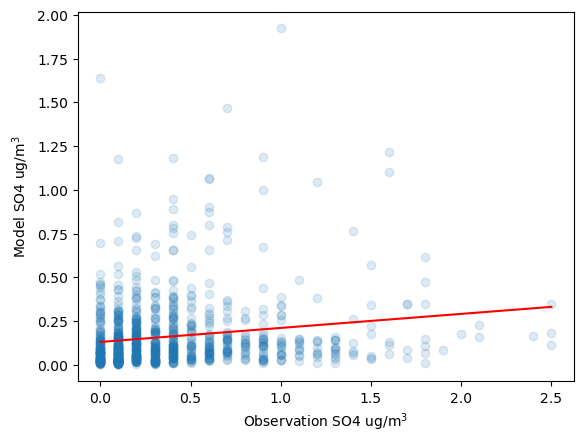

In [116]:
f, ax = plt.subplots()
ax.scatter(x = ALLDATA['SO4'], y = ALLDATA['SO4_tot'],alpha = 0.15)
_dss = ALLDATA.to_dataframe().dropna()
z = np.polyfit(_dss['SO4'], _dss['SO4_tot'], 1)
p = np.poly1d(z)
x= np.linspace(_dss['SO4'].min(), _dss['SO4'].max())
ax.plot( x, p(x), c = col, )
print(p)

plt.xlabel('Observation SO4 ug/m$^3$')
plt.ylabel('Model SO4 ug/m$^3$')

 
0.4528 x + 28.56


Text(0, 0.5, 'Model N50')

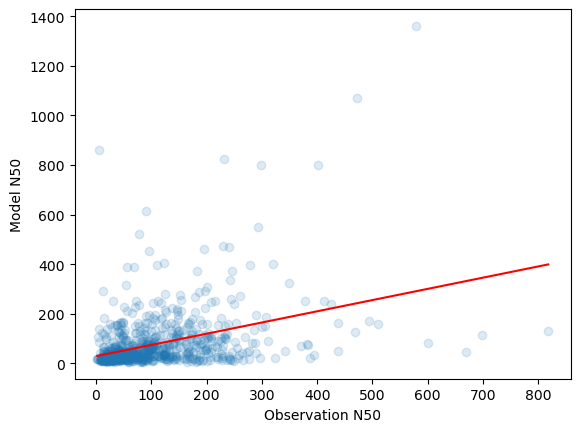

In [117]:
f, ax = plt.subplots()
ax.scatter(x = ALLDATA['N50'], y = ALLDATA['N50_Model'],alpha = 0.15)
_dss = ALLDATA.to_dataframe().dropna()
z = np.polyfit(_dss['N50'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.linspace(_dss['N50'].min(), _dss['N50'].max())
ax.plot( x, p(x), c = col, )
print(p)

plt.xlabel('Observation N50')
plt.ylabel('Model N50')

 
0.1203 x + 15.36


Text(0, 0.5, 'Model N100')

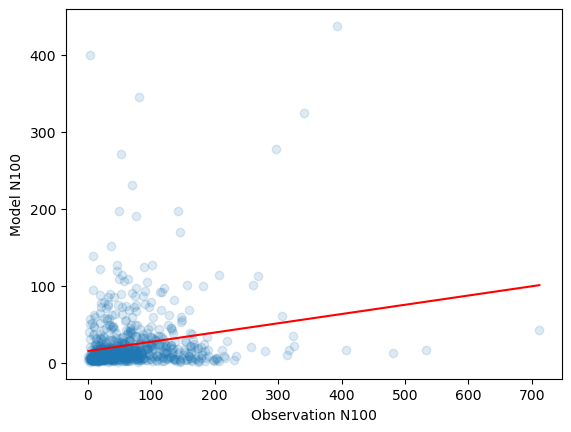

In [118]:
f, ax = plt.subplots()
ax.scatter(x = ALLDATA['N100'], y = ALLDATA['N100_Model'],alpha = 0.15)
_dss = ALLDATA.to_dataframe().dropna()
z = np.polyfit(_dss['N100'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.linspace(_dss['N100'].min(), _dss['N100'].max())
ax.plot( x, p(x), c = col, )
print(p)

plt.xlabel('Observation N100')
plt.ylabel('Model N100')

Flat line means that the model is underestimating the amount of something, steeper means that it is overestimating the amount present.\
A slope of 1 would be that NorESM models the variable perfectly.

## Histogram comparisons between the two variables

(0.0, 4.0)

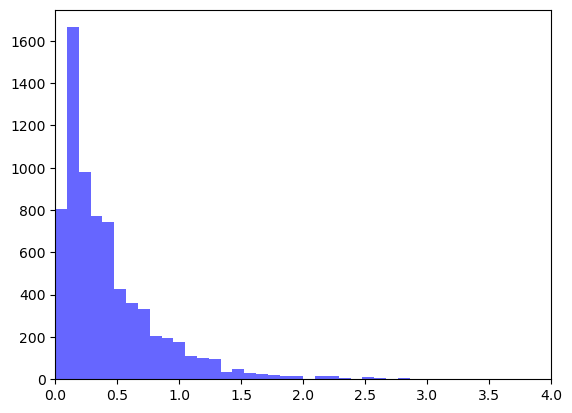

In [215]:
plt.hist(ALLDATA['SO4'], color ='blue', alpha = 0.6, bins = 85)
plt.xlim (0,4)

(0.0, 3.0)

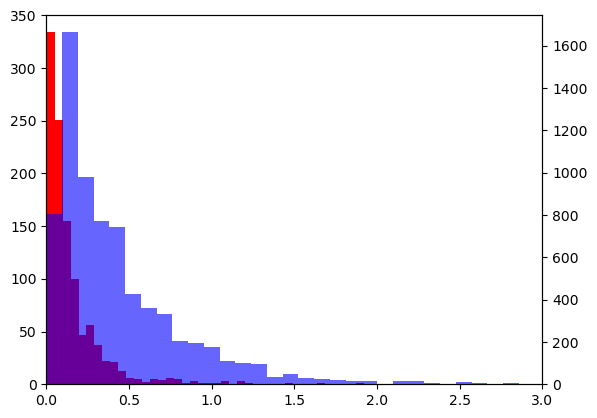

In [223]:
f, ax = plt.subplots()


ax.hist(ALLDATA['SO4_tot'], color = 'red',bins = 40)
ax2 = ax.twinx()
ax2.hist(ALLDATA['SO4'], color ='blue', alpha = 0.6, bins = 85)

ax.set_xlim ([0,3])
ax2.set_xlim ([0,3])

#plt.legend()
#plt.xlabel('SO4 ug/m$^3$')




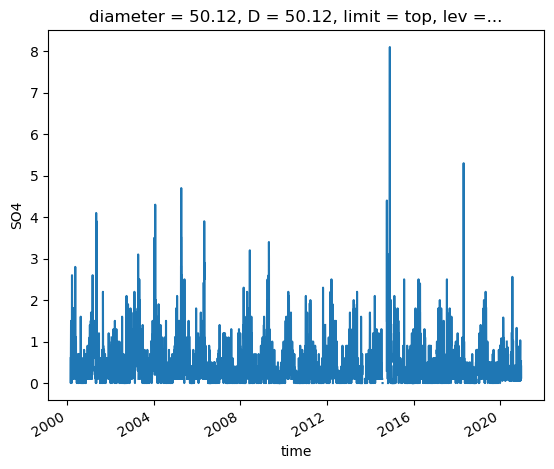

In [217]:
ALLDATA['SO4'].plot()

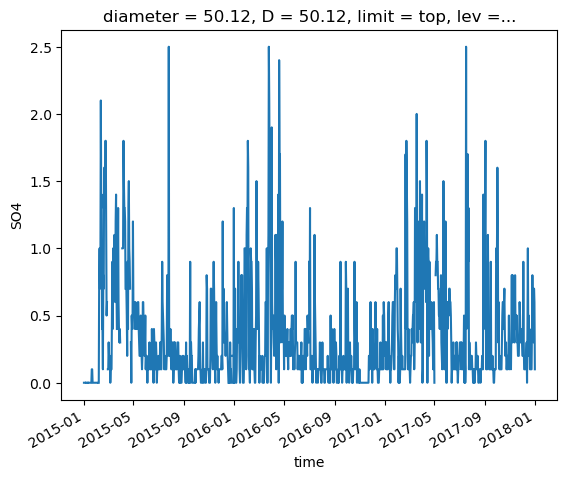

In [218]:
ALLDATA['SO4'].sel(time=slice('2015-01','2017-12')).plot()

(0.0, 3.0)

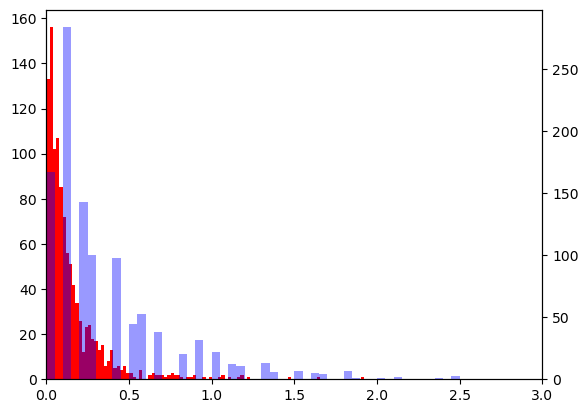

In [225]:
f, ax = plt.subplots()


ax.hist(ALLDATA['SO4_tot'].sel(time=slice('2015-01','2017-12')), color = 'red', bins = 100)
ax2 = ax.twinx()
ax2.hist(ALLDATA['SO4'].sel(time=slice('2015-01','2017-12')), color ='blue', alpha = 0.4, bins = 50)

ax.set_xlim ([0,3])
ax2.set_xlim ([0,3])

#plt.legend()
#plt.xlabel('SO4 ug/m$^3$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

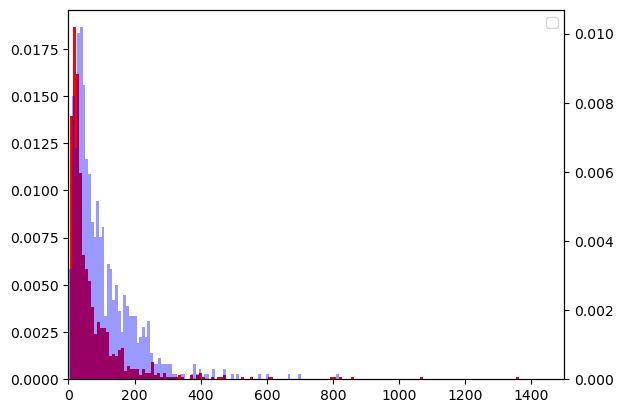

In [186]:
f, ax = plt.subplots()


ax.hist(ALLDATA['N50_Model'].sel(time=slice('2015-01','2017-12')), color = 'red', bins = 150, density = True)
ax2 = ax.twinx()
ax2.hist(ALLDATA['N50'].sel(time=slice('2015-01','2017-12')), color ='blue', alpha = 0.4, bins = 100,density = True)

ax.set_xlim ([0,1500])
plt.y1label = 'Model N50 (Red)'
ax2.set_xlim ([0,1500])
plt.y2label = 'Measured N50 (Blue)'

plt.legend()

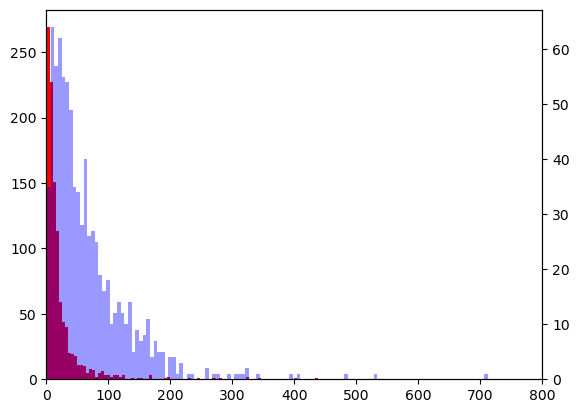

In [182]:
f, ax = plt.subplots()


ax.hist(ALLDATA['N100_Model'].sel(time=slice('2015-01','2017-12')), color = 'red', bins = 90)
ax2 = ax.twinx()
ax2.hist(ALLDATA['N100'].sel(time=slice('2015-01','2017-12')), color ='blue', alpha = 0.4, bins = 120)

ax.set_xlim ([0,800])
plt.y1label = 'Model N100 (Red)'
ax2.set_xlim ([0,800])
plt.y2label = 'Measured N100 (Blue)'
#plt.xlabel ('N50')